<a href="https://colab.research.google.com/github/kobrue02/evaluating-llm-generated-nlu-data/blob/main/bin/notebooks/evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kobrue02/evaluating-llm-generated-nlu-data/
%cd evaluating-llm-generated-nlu-data

Cloning into 'evaluating-llm-generated-nlu-data'...
remote: Enumerating objects: 1017, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 1017 (delta 78), reused 84 (delta 41), pack-reused 884 (from 1)
Receiving objects: 100% (1017/1017), 7.28 MiB | 14.42 MiB/s, done.
Resolving deltas: 100% (676/676), done.
/content/evaluating-llm-generated-nlu-data


In [2]:
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [3]:
from bin.utils.methods import *
from bin.framework.framework import Framework

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

In [5]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [15]:
dataset_names = [
    "attribute_controlled_prompt_data",
    "persona_based_prompt_s1_data",
    "chain_of_thought_simple_data",
    "zero_shot_simple_data",
    "one_shot_simple_data",
    "few_shot_simple_data",
]

In [9]:
ref_df = load_sipgate_dataset()

load phi data

In [17]:
phi_dfs = [load_df(f"phi/{dataset_name}") for dataset_name in dataset_names]

In [18]:
llama_dfs = [load_df(f"llama/llama_{dataset_name}") for dataset_name in dataset_names]

In [ ]:
framework = Framework()
evaluated_sets_phi = []
for gen_df in phi_dfs:
  results = framework.apply_framework_to_datasets(gen_df, ref_df)
  df = results_to_dataframe(results)
  evaluated_sets_phi.append(df)

In [ ]:
dfs_to_stripplots(evaluated_sets_phi)

In [ ]:
framework = Framework()
evaluated_sets_llama = []
for gen_df in llama_dfs:
  results = framework.apply_framework_to_datasets(gen_df, ref_df)
  df = results_to_dataframe(results)
  evaluated_sets_llama.append(df)

In [ ]:
dfs_to_stripplots(evaluated_sets_llama)

In [46]:
def merge_dataframes(evaluated_sets, dataset_names):
    """Merges a list of dataframes into a single dataframe with a new column indicating the prompting strategy.

    Args:
        evaluated_sets: A list of pandas DataFrames.
        dataset_names: A list of strings representing the prompting strategy names.

    Returns:
        A single pandas DataFrame with all data merged and a new "Prompting Strategy" column.
        Returns None if input lists are not of equal length or if any error occurs during processing.
    """
    if len(evaluated_sets) != len(dataset_names):
        print("Error: evaluated_sets and dataset_names must have the same length.")
        return None

    try:
        merged_df = pd.DataFrame()
        for i, df in enumerate(evaluated_sets):
            df['Prompting Strategy'] = dataset_names[i]
            merged_df = pd.concat([merged_df, df], ignore_index=True)
        return merged_df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [35]:
merged_phi_df = merge_dataframes(evaluated_sets_phi, dataset_names)
merged_llama_df = merge_dataframes(evaluated_sets_llama, dataset_names)

In [37]:
# prompt: now concatenate the two merged dataframes and add a new column "Model"

concatenated_df = pd.concat([merged_phi_df, merged_llama_df], ignore_index=True)
concatenated_df["Model"] = ""  # Add a new column named "Model" initialized with empty strings
concatenated_df.loc[concatenated_df.index < len(merged_phi_df), "Model"] = "Phi"
concatenated_df.loc[concatenated_df.index >= len(merged_phi_df), "Model"] = "Llama"

In [61]:
concatenated_df

,distinct_1,distinct_2,ttr,moving_average_ttr,average_n_of_tokens,average_n_of_characters,distance_to_centroid,discourse_coherence,inter_sentence_similarity,pos_tag_n_grams_diversity,bleu,mean_levenshtein_distance,intent,Model,Prompting Strategy
0,0.304,0.527,0.286,0.635,4.308,30.538,0.597,1.245,0.604,0.942,0.138,23.778,account_activate_item,Phi,attribute_controlled_prompt_data
1,0.201,0.388,0.201,0.898,7.160,42.520,0.633,1.197,0.554,0.846,0.272,30.054,account_ask_item_available,Phi,attribute_controlled_prompt_data
2,0.314,0.624,0.256,0.751,3.440,23.520,0.631,1.054,0.574,0.399,0.578,17.686,account_delete_item,Phi,attribute_controlled_prompt_data
3,0.381,0.704,0.362,0.857,6.400,48.640,0.703,0.805,0.448,0.720,0.375,69.490,account_merge,Phi,attribute_controlled_prompt_data
4,0.216,0.391,0.210,0.842,6.480,43.200,0.678,1.216,0.493,0.716,0.287,68.195,account_terminate,Phi,attribute_controlled_prompt_data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,0.550,0.769,0.525,0.833,4.000,21.000,0.678,1.306,0.475,0.900,0.276,25.948,qr_feedback_negative,Llama,few_shot_simple_data
843,0.268,0.518,0.239,0.837,5.917,37.000,0.578,1.160,0.637,0.868,0.133,33.378,request_migrate_product,Llama,few_shot_simple_data
844,0.359,0.632,0.333,0.807,3.900,22.000,0.685,1.629,0.474,0.825,0.370,20.640,service_disruption_inquire,Llama,few_shot_simple_data
845,0.236,0.563,0.222,0.698,3.429,29.143,0.546,1.404,0.666,0.492,0.113,22.973,softphone_request_info,Llama,few_shot_simple_data


In [51]:
ref_eval = framework.apply_framework_to_datasets(ref_df)

100%|██████████| 92/92 [00:05<00:00, 17.23it/s]


In [62]:
ref_eval_df = results_to_dataframe(ref_eval)
ref_eval_df["Prompting Strategy"] = "Sipgate"
ref_eval_df["Model"] = "Human"
concatenated_df = pd.concat([concatenated_df, ref_eval_df], ignore_index=True)

In [ ]:
concatenated_df

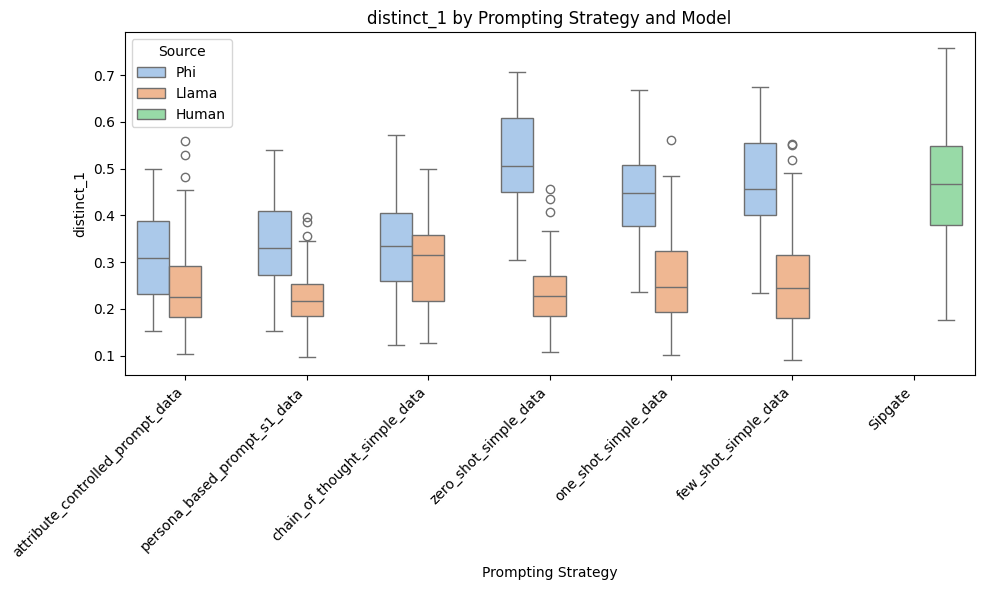

<Figure size 640x480 with 0 Axes>

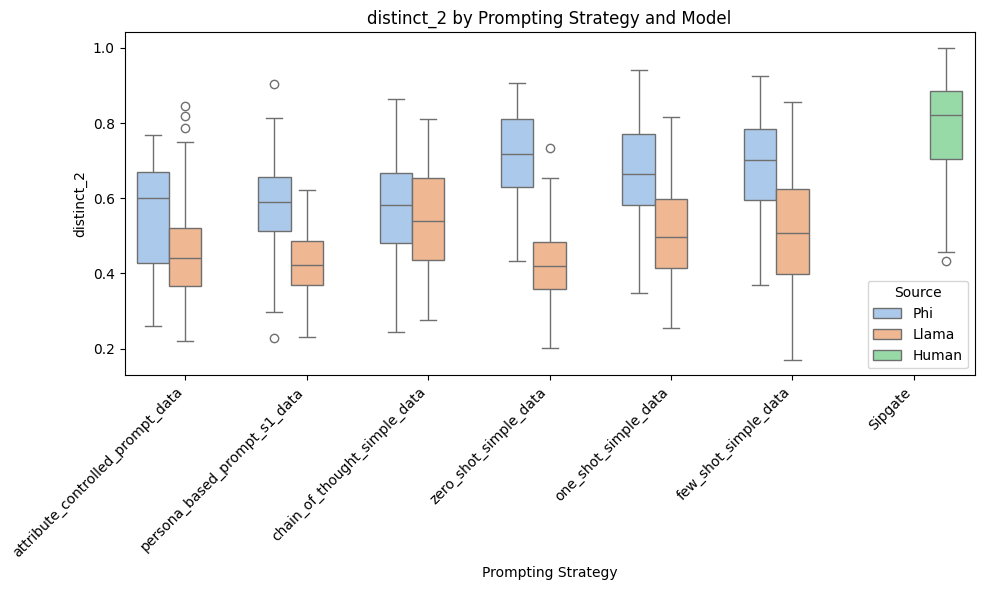

<Figure size 640x480 with 0 Axes>

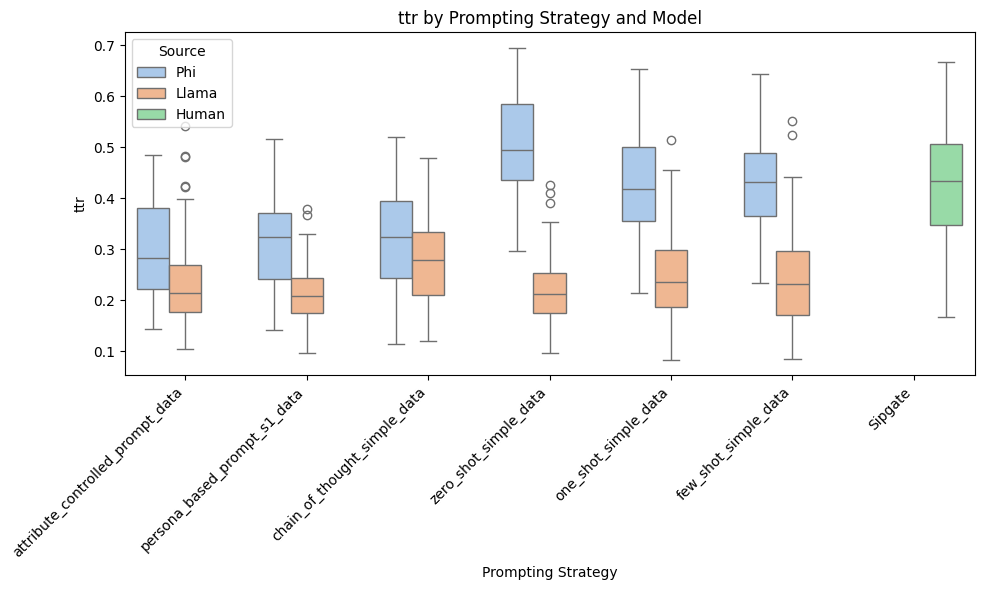

<Figure size 640x480 with 0 Axes>

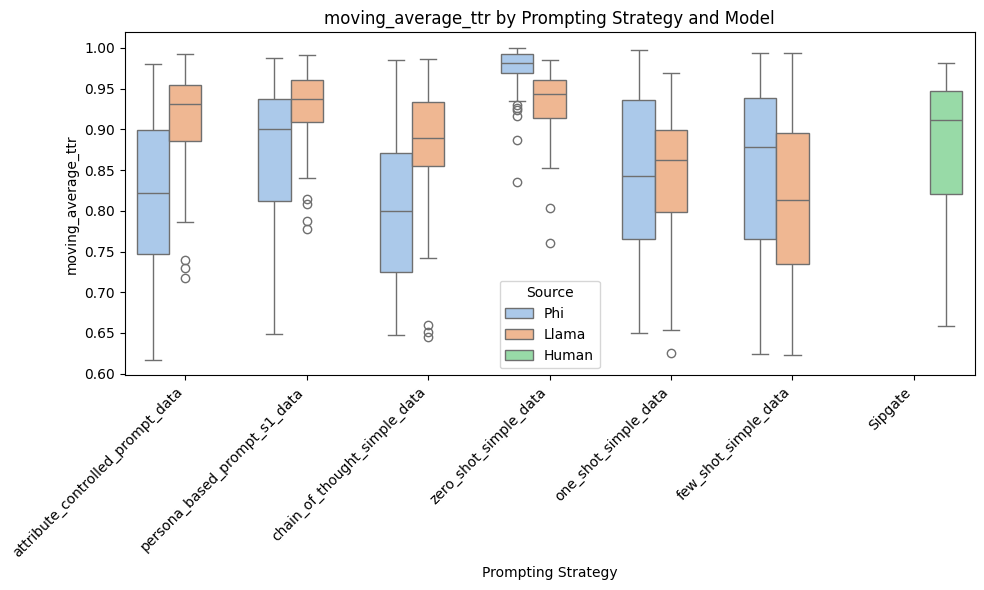

<Figure size 640x480 with 0 Axes>

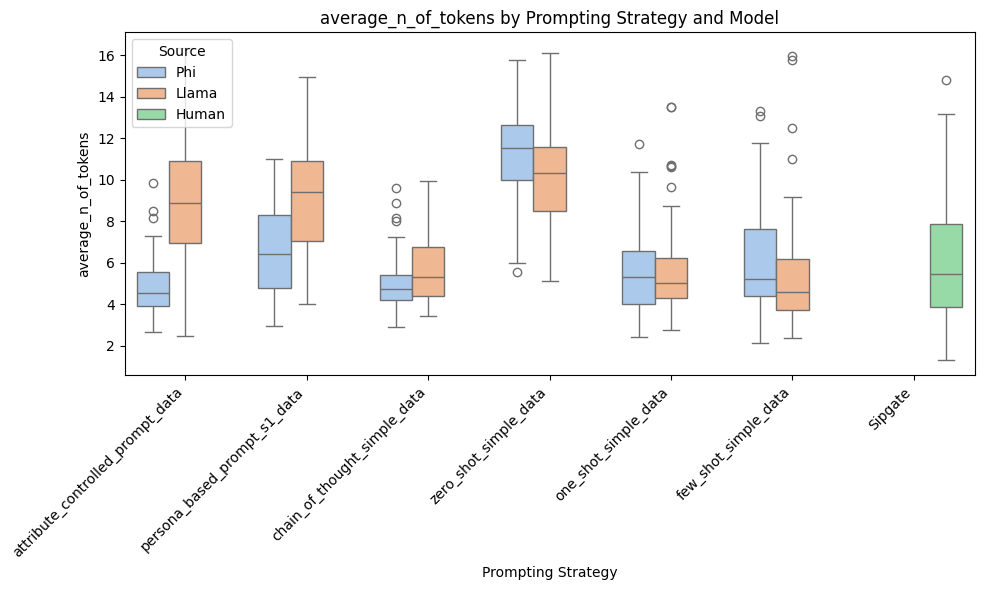

<Figure size 640x480 with 0 Axes>

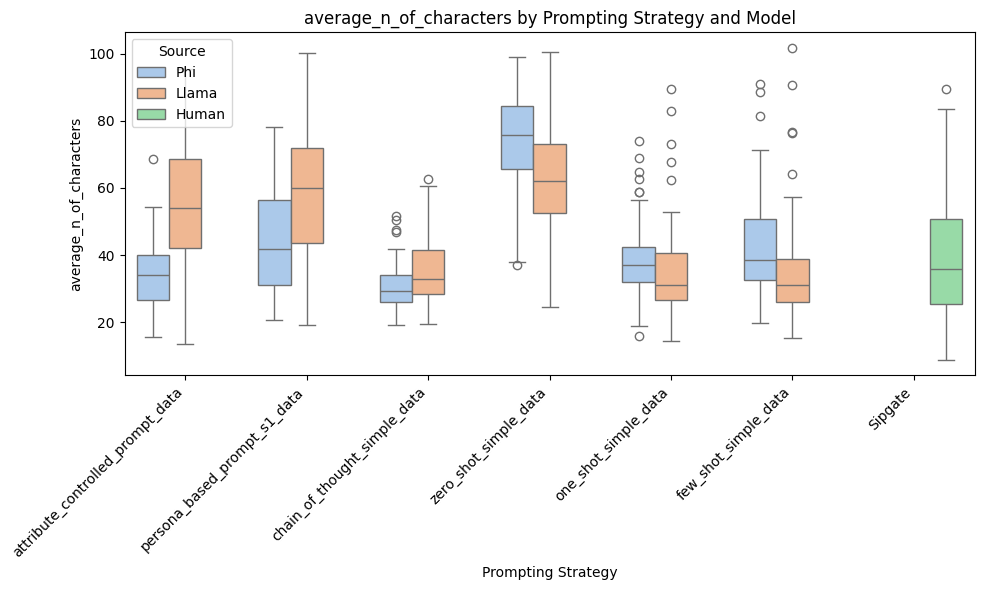

<Figure size 640x480 with 0 Axes>

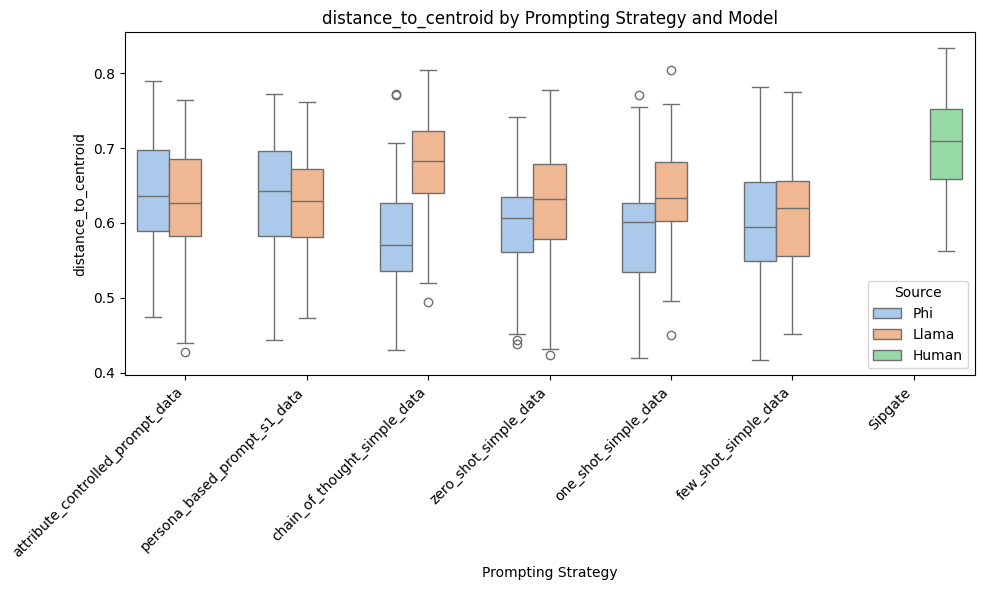

<Figure size 640x480 with 0 Axes>

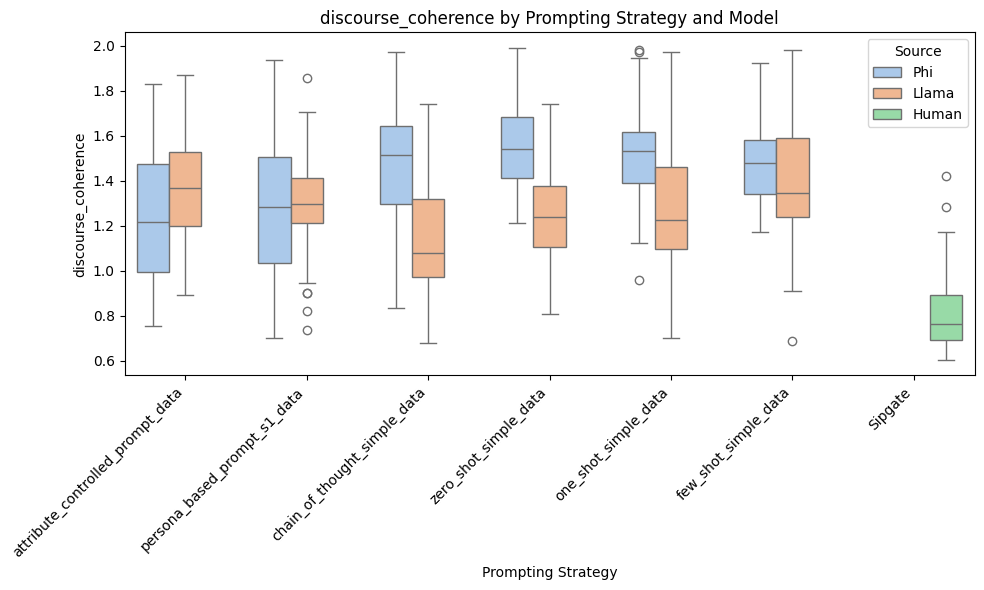

<Figure size 640x480 with 0 Axes>

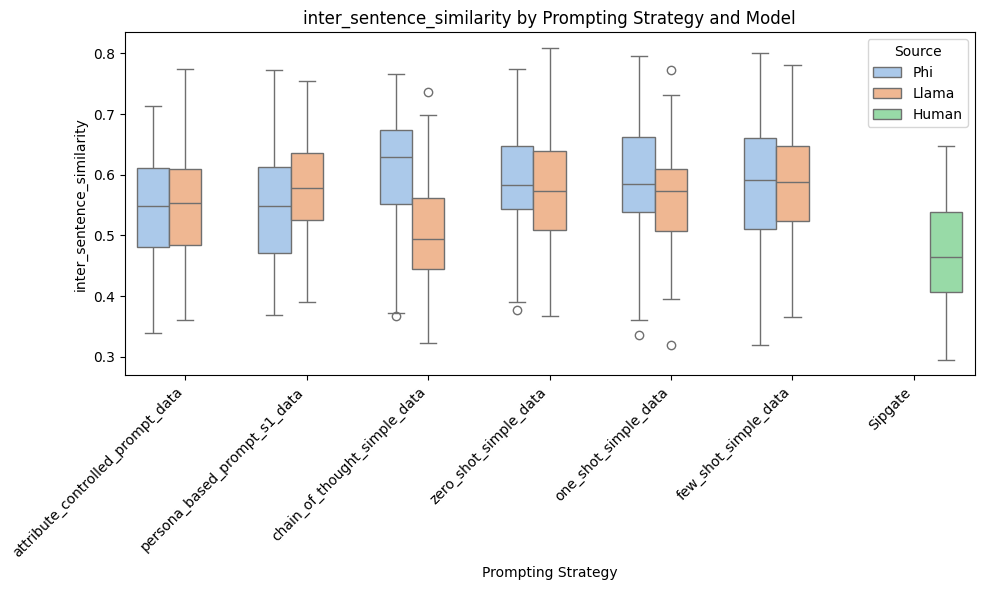

<Figure size 640x480 with 0 Axes>

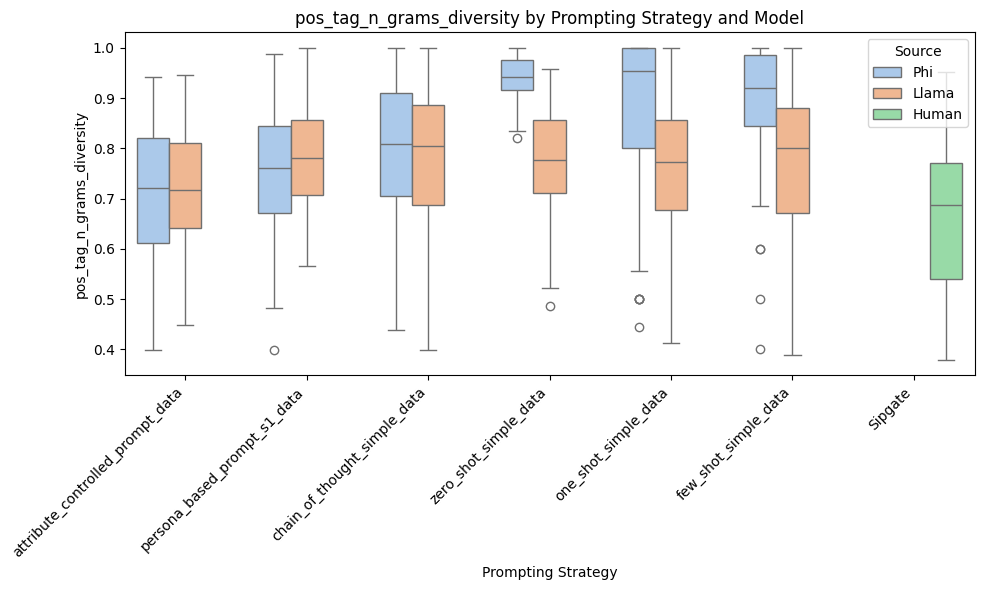

<Figure size 640x480 with 0 Axes>

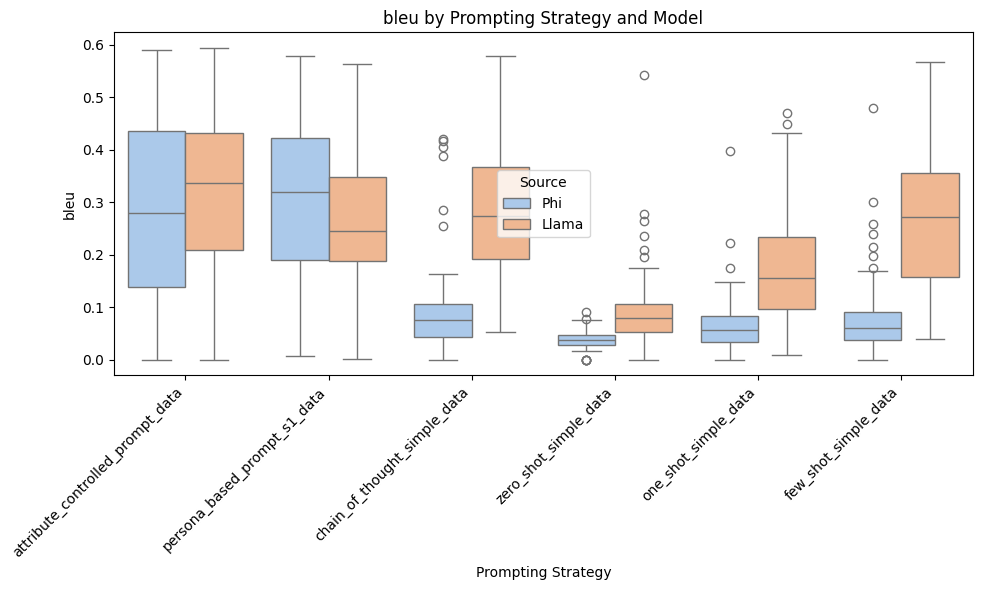

<Figure size 640x480 with 0 Axes>

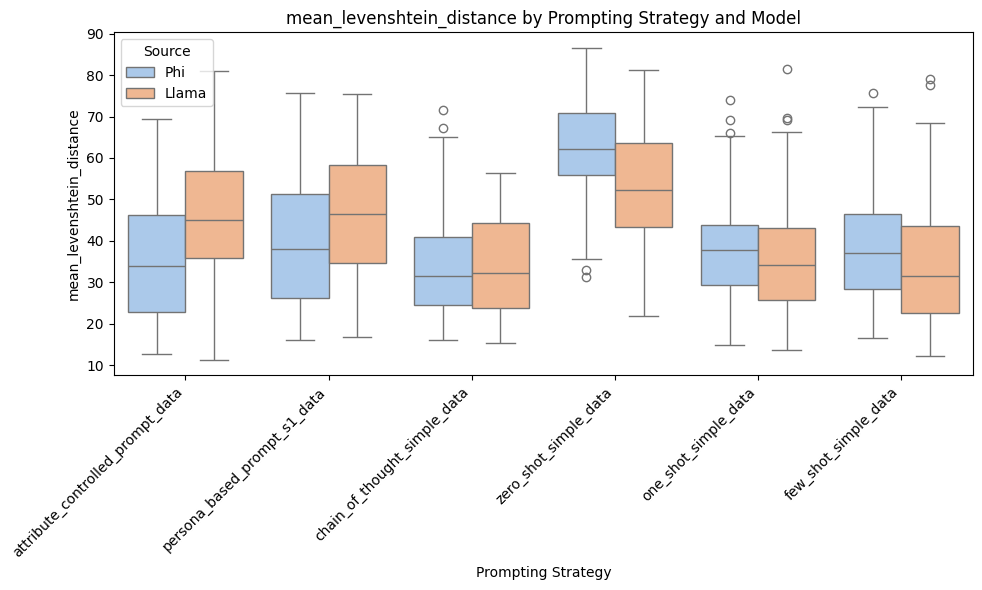

<Figure size 640x480 with 0 Axes>

In [64]:
metrics = [col for col in concatenated_df.columns if col not in ["Prompting Strategy", "Model"]]

for metric in metrics:
    if metric in ["intent", "Dataset"]:
        continue
    plt.figure(figsize=(10, 6))
    # remove extreme outliers
    q1 = concatenated_df[metric].quantile(0.25)
    q3 = concatenated_df[metric].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    concatenated_df = concatenated_df[(concatenated_df[metric] >= lower_bound) & (concatenated_df[metric] <= upper_bound)]
    sns.boxplot(
        x="Prompting Strategy",
        y=metric,
        hue="Model",
        data=concatenated_df,
        palette="pastel")
    plt.title(f"{metric} by Prompting Strategy and Model")
    plt.xticks(rotation=45, ha='right')
    # rename the legend to "Source"
    plt.legend(title="Source")
    plt.tight_layout()
    plt.show()
    # save each plot
    plt.savefig(f"{metric}.png")

In [65]:
from scipy.spatial.distance import jensenshannon
def js_divergence(p, q):
  p = np.asarray(p)
  q = np.asarray(q)
  return jensenshannon(p, q)